In [2]:
%%HTML
<style>
    body {
        --vscode-font-family: "KoddiUD 온고딕"
    }
</style>

In [3]:
# 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

In [4]:
# 한글 폰트 설정

# pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

# 0. 데이터 불러오기
- 데이터 명세
  | 테이블명             | 테이블 설명                    | 주요 컬럼                                                                                                                     | 비고                                                                                                                                                                                   |
  |----------------------|-------------------------------|------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
  | **company**          | 기업 마스터 테이블             | 기업id, 기업 생성일, 마지막 기업 정보 수정일, 설립일, 구성원 수, 기업 팔로워 수, 기업 추천 수                                    |                                                                                                                                                                                      |
  | **company_address**  | 기업 주소지 정보 테이블         | 기업id, 기업 상위 주소지 정보, 주소지명(Ex. 본사)                                                                              |                                                                                                                                                                                      |
  | **company_funding**  | 기업 투자 정보 테이블           | 기업id, 투자유치일, 투자단계, 투자유치금, 통화(KRW/USD)                                                                        |                                                                                                                                                                                      |
  | **job**              | 채용공고 마스터 테이블          | 채용공고id, 기업id, 생성일, 마지막 수정일, 채용분야, 채용시작일, 채용마감일, 경력, 연봉공개여부, 원격근무가능여부                  |                                                                                                                                                                                      |
  | **job_address**      | 채용공고 주소지 정보 테이블      | 채용공고id, 근무지 상위 주소지 정보, 근무지명                                                                                  | 기업은 여러 개의 주소지를 보유할 수 있고, 채용공고별로 근무지를 선택할 수 있음.                                                                                                        |
  | **job_bookmark**     | 채용 북마크 트랜잭션 테이블      | 유저id, 채용공고id, 북마크일시                                                                                                 |                                                                                                                                                                                      |
  | **application**      | 지원서 마스터 테이블            | 지원서id, 유저id, 채용공고id, 지원일시                                                                                        | 현재 하나의 채용공고에 유저가 여러 번 지원할 수 있음. 채용담당자가 재지원을 요구하기도 함.                                                                                              |
  | **log**              | 사용자 로그 테이블              | 유저id, 이벤트 발생 화면경로, 직전 화면경로, 로그 생성 일시, HTTP 요청 메소드, HTTP 응답 코드                                   | "구직자의 로그 데이터만 제공합니다. 로그를 통해 확인 가능한 이벤트는 아래와 같습니다. |  
1. 플랫폼 서비스 웹 내에서의 페이지 이동 및 이벤트 전체
(*단, 개인정보 이슈상 아래 이벤트를 제외)
   - 메시지 수신
   - 메시지 송신
   - 연결신청
   - 연결신청 수락 등

2. 채용서비스 관련 각종 이벤트 예시
(*모두 1에 포함되는 데이터)
   - 채용정보 조회
   - 채용 기업 페이지 조회
   - 채용 기업의 구성원 프로필 조회
   - 지원서 업데이트 (개인정보 이슈상, 어떤 내용이 업데이트되었는지는 미제공)
   - 채용공고 북마크
                                          

In [5]:
df_log_2023 = pd.read_csv('data/log_2023.csv')
df_log_2022 = pd.read_csv('data/log_2022.csv')
df_application = pd.read_csv('data/Application.csv')
df_company = pd.read_csv('data/Company.csv')
df_company_address = pd.read_csv('data/CompanyAddress.csv')
df_company_fund = pd.read_csv('data/CompanyFund.csv')
df_job = pd.read_csv('data/Job.csv')
df_job_address = pd.read_csv('data/JobAddress.csv')
df_job_bookmark = pd.read_csv('data/JobBookmark.csv')

# 1. 데이터 살펴보기

## 1.1 테이블별 기본 정보 확인

In [6]:
# Basic EDA
basic_eda_result = {}
def basic_eda(df):
  summary = {
        'info': df.info,
        'shape': df.shape,
        'columns': df.columns.tolist(),
        'describe': df.describe(include = 'all'),
        'head': df.head().to_dict(orient='records'),
        'missing values': df.isnull().sum().to_dict(),
        'duplicated values': df.duplicated().sum()
    }
  return summary
basic_eda_result['log_2022'] = basic_eda(df_log_2022)
basic_eda_result['log_2023'] = basic_eda(df_log_2023)
basic_eda_result['application'] = basic_eda(df_application)
basic_eda_result['company'] = basic_eda(df_company)
basic_eda_result['company_address'] = basic_eda(df_company_address)
basic_eda_result['company_fund'] = basic_eda(df_company_fund)
basic_eda_result['job'] = basic_eda(df_job)
basic_eda_result['job_address'] = basic_eda(df_job_address)
basic_eda_result['job_bookmark'] = basic_eda(df_job_bookmark)

basic_eda_result

{'log_2022': {'info': <bound method DataFrame.info of           Unnamed: 0                             user_uuid  \
  0                  0  8a7e70cd-1630-4a8a-8303-0706af3a7908   
  1                  1  8a7e70cd-1630-4a8a-8303-0706af3a7908   
  2                  2  8a7e70cd-1630-4a8a-8303-0706af3a7908   
  3                  3  8a7e70cd-1630-4a8a-8303-0706af3a7908   
  4                  4  8a7e70cd-1630-4a8a-8303-0706af3a7908   
  ...              ...                                   ...   
  10054119    10054119  d2b90cda-7e0d-454f-8a64-070048551e14   
  10054120    10054120  5ddc8a26-b006-4f26-b576-08095d22cf8a   
  10054121    10054121  f9387b22-2d7d-4267-8671-2279e2d784b9   
  10054122    10054122  849ff1bb-6280-46f4-baaa-71d1d0796b5b   
  10054123    10054123  940b883f-a385-416c-94e2-b5604a78506c   
  
                                                          URL  \
  0              api/search/language?name=한국어&_=1655915651225   
  1                                           a

### 테이블별 특성 파악

- df_log_2022
  - 주요 컬럼
    - user_uuid, URL, timestamp, date, response_code, method
  - 총 10,054,124개의 로그 데이터
  - 사용자 수(user_uuid)
    - 17,112명
  - 가장 많이 접속한 URL
    - 'jobs/id/id_title'로 677,627회 접속
  - HTTP 응답 코드
    - 평균 202.7로, 대부분 성공적인 요청
  - method
    - GET 메소드가 가장 많이 사용됨
  
- df_log_2023
  - 주요 컬럼
    - df_log_2022와 같음
  - 총 7,187,783개의 로그 데이터
  - 사용자 수(user_uuid)
    - 15,366명으로 2022년보다 감소
  - 가장 많이 접속한 URL
    - 'api/users/id/template'로 529,724회 접속
  - HTTP 응답 코드
    - 평균 202.9로 2022년과 비슷한 수준
    - GET 메소드가 여전히 가장 많이 사용

- df_application
  - 주요 컬럼
    - cdate, company_uuid, job_uuid, user_uuid, application_uuid
  - 총 340,730개의 지원 데이터
  - 회사 수
    - 11,307개
  - 채용공고 수
    - 72,408개
  - 지원자 수
    - 36,732명
  - 가장 많은 지원을 받은 채용공고
    - 'f7afddc2-90a5-45aa-9173-913d3b36eca8'로 649회 지원
  - 가장 많이 지원한 사용자
    - '2ece8d7d-79b6-4522-928b-8dbae8843fab'로 41,713회 지원
  
- df_company
  - 주요 컬럼
    - cdate, mdate, found_date, employee_count, view_count, follow_count, reference_count, company_uuid
  - 총 41,659개의 회사 데이터
  - 대부분의 회사(34,978개)가 직원 수를 '0명'으로 보고
  - 평균 조회 수
    - 1,661.77회
  - 평균 팔로우 수
    - 10.17회
  - 평균 참조 수
    - 0.74회
  - 가장 높은 조회 수
    - 575,596회
  - 가장 높은 팔로우 수
    - 2,740회
  
- df_company_address
  - 주요 컬럼
    - name, company_uuid, address
  - 총 17,301개의 회사 주소 데이터
  - 가장 많이 등록된 주소명
    - '본사'로 4,788회 등록
    - 가장 많이 등록된 주소
      - '서울특별시 강남구'로 4,093회 등록
    - 14,033개의 회사가 주소를 등록
- df_company_funding
  - 주요 컬럼
    - company_uuid, investment_date, investment_stage, investment_amount, currency
  - 총 3,309개의 투자 데이터
  - 회사 수
    - 1,940개
  - 평균 투자 금액
    - 약 1,090만 달러
  - 최대 투자 금액
    - 3억 달러
  - 가장 많은 투자를 받은 회사
    - '721545ea-086b-4e50-9e60-ccc679a43607'로 총 7억 1,500만 달러
  - 가장 흔한 투자 단계
    - 'SeriesA'로 1,026건
- df_jobs
  - 주요 컬럼
    - cdate, mdate, company_uuid, job_uuid, job_category, job_start_date, job_end_date, experience, salary_disclosed, remote_work
  - 총 72,408개의 채용공고 데이터
  - 회사 수
    - 11,307개
  - 가장 많은 채용 공고를 올린 회사
    - '721545ea-086b-4e50-9e60-ccc679a43607'로 649개
  - 평균 채용 공고 기간
    - 약 45일
  - 가장 흔한 채용 분야
    - '개발'로 20,385건
  - 연봉 공개 비율
    - 약 32%
  - 원격 근무 가능 비율
    - 약 18%
- df_job_address
  - 주요 컬럼
    - job_uuid, address, name
  - 총 72,408의 채용공고 주소 데이터
  - 가장 많이 등록된 근무지
    - '서울특별시 강남구'로 17,245건
  - 근무지 수
    - 528개
  - 채용공고당 평균 근무지 수
    - 1개 (대부분의 채용공고가 하나의 근무지만 등록)
- df_job_bookmark
  - 주요 컬럼
    - user_uuid, job_uuid, cdate
  - 총 1,019,916개의 북마크 데이터
  - 사용자 수
    - 13,996명
  - 채용공고 수
    - 67,401개
  - 가장 많이 북마크된 채용공고
    - 'f7afddc2-90a5-45aa-9173-913d3b36eca8'로 1,297회
  - 가장 많은 북마크를 한 사용자
    - '2ece8d7d-79b6-4522-928b-8dbae8843fab'로 41,713개

### 테이블 간 관계
- 기업 관련 테이블
  - company와 company_address
    - 1:N 관계로, 하나의 기업(company_uuid)이 여러 주소를 가질 수 있음
  - company와 company_funding
    - 1:N 관계로, 하나의 기업(company_uuid)이 여러 번의 투자를 받을 수 있음
  
- 채용 공고 관련 테이블
  - company와 job
    - 1:N 관계로, 하나의 기업(company_uuid)이 여러 채용 공고를 게시할 수 있음
  - job과 job_address
    - 1:N 관계로, 하나의 채용 공고(job_uuid)가 여러 근무지를 가질 수 있음
  - job과 job_bookmark:
    - 1:N 관계로, 하나의 채용 공고(job_uuid)를 여러 사용자가 북마크할 수 있음

- 지원 관련 테이블
  - job과 application
    - 1:N 관계로, 하나의 채용 공고(job_uuid)에 여러 지원서가 제출될 수 있음
  - company와 application
    - 1:N 관계로, 하나의 기업(company_uuid)에 여러 지원서가 제출될 수 있음
- 사용자 활동 관련 테이블
  - log_2022와 log_2023
    - 사용자 활동 로그를 연도별로 분리하여 저장
    - user_uuid를 통해 사용자의 활동을 추적 가능
    - job_uuid, company_uuid 등을 통해 다른 테이블과 연결 가능
___
- 공통 컬럼
  - user_uuid
    - log_2022와 log_2023, application
  - company_uuid와 job_uuid
    - application, company와 job
  - company_uuid
    - company, company_address, company_fund, job

## 1.2 결측치 시각화

In [7]:
def calculate_missing(df):
    missing = df.isnull().sum()
    missing_percent = 100 * df.isnull().sum() / len(df)
    missing_table = pd.concat([missing, missing_percent], axis=1, keys=['missing_count', 'percentage'])
    missing_table = missing_table[missing_table.missing_count != 0].sort_values('percentage', ascending=False).round(1)
    return missing_table

In [8]:
# 각 데이터프레임에 대해 결측치 계산
missing_log_2022 = calculate_missing(df_log_2022)
missing_log_2023 = calculate_missing(df_log_2023)
missing_application = calculate_missing(df_application)
missing_company = calculate_missing(df_company)
missing_company_address = calculate_missing(df_company_address)
missing_company_fund = calculate_missing(df_company_fund)
missing_job = calculate_missing(df_job)
missing_job_address = calculate_missing(df_job_address)
missing_job_bookmark = calculate_missing(df_job_bookmark)

In [9]:
# 결과 병합
missing_combined = pd.concat([
    missing_log_2022, missing_log_2023, missing_application, 
    missing_company, missing_company_address, missing_company_fund, missing_job, missing_job_address, missing_job_bookmark
], keys=['log_2022', 'log_2023', 'application', 'company', 'company_address', 'company_fund', 'job', 'job_address', 'job_bookmark'])

missing_combined = missing_combined.reset_index().rename(columns={'level_0': 'dataset', 'level_1': 'column'})

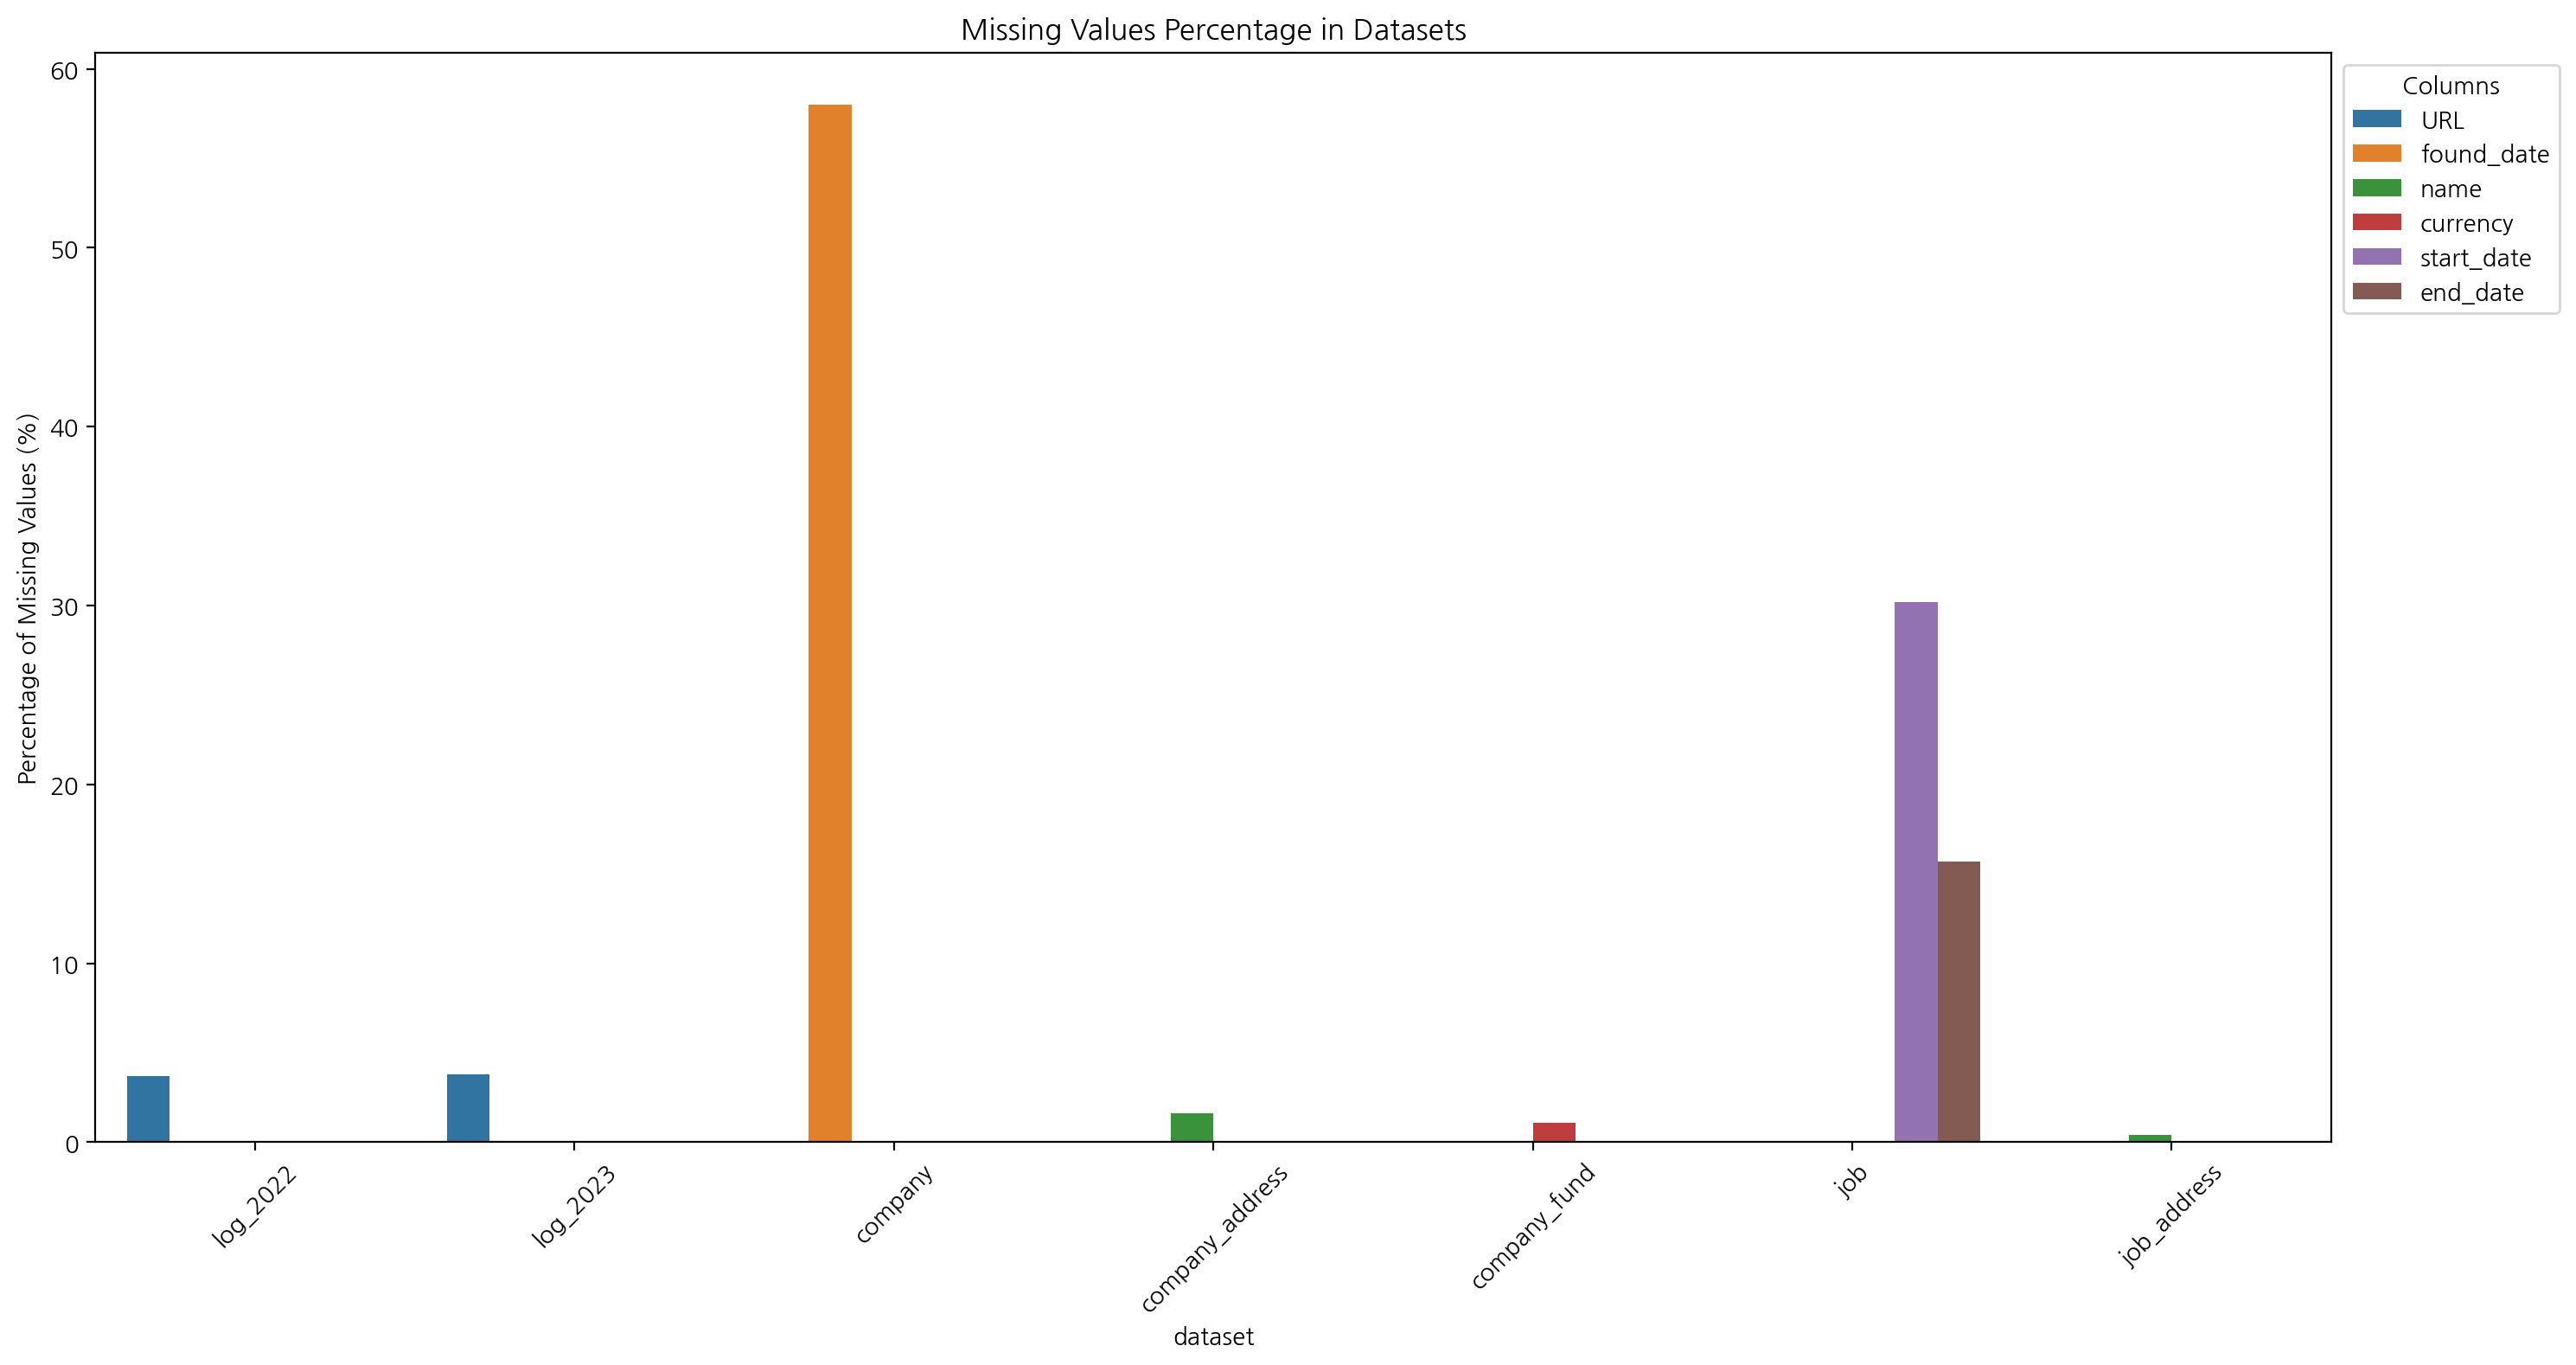

In [10]:
# 결측치 시각화
plt.figure(figsize=(15, 8))
sns.barplot(data=missing_combined, x='dataset', y='percentage', hue='column')
plt.title('Missing Values Percentage in Datasets')
plt.ylabel('Percentage of Missing Values (%)')
plt.xticks(rotation=45)
plt.legend(title='Columns', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
missing_combined

,dataset,column,missing_count,percentage
0,log_2022,URL,369434,3.7
1,log_2023,URL,274722,3.8
2,company,found_date,24175,58.0
3,company_address,name,279,1.6
4,company_fund,currency,103,1.1
5,job,start_date,43531,30.2
6,job,end_date,22718,15.7
7,job_address,name,19,0.4


# 2. 전처리

## 2.1 결측치 처리

### df_log_2022, df_log_2023

In [12]:
df_log_2022.head()

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method
0,0,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/search/language?name=한국어&_=1655915651225,2022-06-22 16:42:48.247454 UTC,2022-06-23,200,GET
1,1,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/signup/form,2022-06-22 16:19:07.770741 UTC,2022-06-23,200,POST
2,2,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/users/id/template,2022-06-22 16:41:54.449837 UTC,2022-06-23,200,POST
3,3,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/users/id/template,2022-06-23 02:53:47.040932 UTC,2022-06-23,200,POST
4,4,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/users/id/phone/verify/template?_=165591488...,2022-06-22 16:21:58.154299 UTC,2022-06-23,200,GET


In [13]:
missing_log_2022 = df_log_2022[df_log_2022.isna().any(axis=1)]
missing_log_2022.head()

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method
11,11,8a7e70cd-1630-4a8a-8303-0706af3a7908,NaN,2022-06-26 08:11:12.699045 UTC,2022-06-26,200,GET
21,21,8a7e70cd-1630-4a8a-8303-0706af3a7908,NaN,2022-06-24 09:27:02.766803 UTC,2022-06-24,200,GET
67,67,8a7e70cd-1630-4a8a-8303-0706af3a7908,NaN,2022-06-26 08:11:25.534668 UTC,2022-06-26,200,GET
68,68,8a7e70cd-1630-4a8a-8303-0706af3a7908,NaN,2022-06-26 08:13:07.108177 UTC,2022-06-26,200,GET
70,70,8a7e70cd-1630-4a8a-8303-0706af3a7908,NaN,2022-06-23 16:40:27.949292 UTC,2022-06-24,200,GET


- URL 값이 없으면 어떤 페이지로 넘어갔는지 몰라 나중에 분석이 어려울 것 같음
  - 2022에는 퍼센트 3.7 2023에는 3.8
    - 비중이 높지 않아 후에 제외하고 분석하거나 URL 값이 없는 것들만 다시 자세히 살펴봐야할 것 같음

- 지금은 우선 Unknown으로 처리

In [14]:
df_log_2022['URL'] = df_log_2022['URL'].fillna('Unknown')
df_log_2023['URL'] = df_log_2023['URL'].fillna('Unknown')

### df_company

In [15]:
df_company.head()

,Unnamed: 0,cdate,mdate,found_date,employee_count,view_count,follow_count,reference_count,company_uuid
0,0,2022-06-09 04:08:40,2022-06-09 04:08:40,NaN,0명,0,0,0,c46f2fa5-f940-40fb-bd4a-aa0ff7a837fd
1,1,2017-05-22 10:57:12,2022-07-25 00:12:02,NaN,0명,256,0,0,725e87bb-de2f-416a-a6b8-1ca8d0d096e0
2,2,2017-11-14 11:42:55,2022-11-04 03:29:16,NaN,0명,256,0,0,efa3747d-9bbd-4c84-af51-82ccf6545dcd
3,3,2017-11-27 10:59:30,2021-01-17 14:42:06,NaN,0명,256,0,0,84aa2c20-d0f3-4ec3-ac06-1ef67e071b8f
4,4,2018-01-08 14:41:58,2022-07-25 01:34:16,2018-01-08,0명,256,0,0,761e76b3-507c-4c8f-b96f-fa47a8ccb5f2


- 분석을 진행하며 필요에 따라 처리 방법이 달라질 것 같아서 일단 그냥 두고 필요할 때 처리

### df_company_address

In [16]:
df_company_address.head()

,Unnamed: 0,name,company_uuid,address
0,0,NaN,0bf81092-9bb5-44c7-a8de-e1db103253ef,서울 구로구
1,1,사무실,0bf81092-9bb5-44c7-a8de-e1db103253ef,서울특별시 구로구
2,2,NaN,e8b24030-b0c5-4f07-9427-2d1e2519cb82,"158 Hoàng Hoa Thám, Phường 12, Tân Bình, Hồ Ch..."
3,3,NaN,21743ac5-8957-4b2e-8f36-804d187d75a5,서울특별시 서초구
4,4,NaN,82be7598-af6f-4af9-86d5-f57ccb76f8dd,서울특별시 종로구


name 결측치 미지정으로 처리

In [17]:
df_company_address['name'] = df_company_address['name'].fillna('미지정')

### df_company_fund

In [18]:
df_company_fund.head()

,Unnamed: 0,fund_date,round_type,raised,currency,company_uuid
0,0,2015-01-15,Seed,0,KRW,2bf21122-15b6-4e6e-ae32-6e25968246f6
1,1,2016-05-31,Seed,0,KRW,2bf21122-15b6-4e6e-ae32-6e25968246f6
2,2,2014-08-25,Angel,0,NaN,2bf21122-15b6-4e6e-ae32-6e25968246f6
3,3,2014-07-17,Seed,0,NaN,2495f29e-64dc-4b83-9e55-5ff0702a4b22
4,4,2015-05-12,투자 단계 비공개,0,KRW,2495f29e-64dc-4b83-9e55-5ff0702a4b22


In [19]:
missing_company_fund = df_company_fund[df_company_fund.isnull().any(axis=1)]
missing_company_fund.head(10)

,Unnamed: 0,fund_date,round_type,raised,currency,company_uuid
2,2,2014-08-25,Angel,0,NaN,2bf21122-15b6-4e6e-ae32-6e25968246f6
3,3,2014-07-17,Seed,0,NaN,2495f29e-64dc-4b83-9e55-5ff0702a4b22
5,5,2014-04-13,Seed,0,NaN,5b0f9672-ded0-4824-9cff-f54fe6fb4dc6
6,6,2014-11-16,투자 단계 비공개,0,NaN,5b0f9672-ded0-4824-9cff-f54fe6fb4dc6
7,7,2013-12-05,Seed,0,NaN,dd5d2bb2-d2ec-4d71-bf94-2edb465a7a10
8,8,2014-03-20,Seed,0,NaN,dd5d2bb2-d2ec-4d71-bf94-2edb465a7a10
10,10,2014-12-09,해당없음,0,NaN,dd5d2bb2-d2ec-4d71-bf94-2edb465a7a10
11,11,2015-06-19,해당없음,0,NaN,dd5d2bb2-d2ec-4d71-bf94-2edb465a7a10
13,13,2014-12-20,Seed,0,NaN,b0b78bf6-4040-4c0d-aa02-da573dac34b6
14,14,2015-07-11,Seed,0,NaN,d04c24ee-55ba-4cd1-9ffb-f5e08a595d3b


- 별 다른 규칙을 보이지 않으며, 
- 분석을 진행하며 필요에 따라 처리 방법이 달라질 것 같아서 일단 그냥 두고 필요할 때 처리

### df_job

In [20]:
df_job.head(10)

,Unnamed: 0,cdate,mdate,job_field,career_type_string,start_date,end_date,allow_remote,can_show_salary,job_uuid,company_uuid
0,0,2020-11-25 10:32:10,2020-11-25 10:32:10,SW 개발,"신입,경력,인턴",NaN,2020-11-25,1,0,764292b0-53f8-4f14-ac83-6eafc7a6a18d,daa34559-fc42-47f6-b5c6-cc6171404f37
1,1,2020-12-03 16:24:16,2020-12-03 16:24:16,HW 개발,인턴,2020-12-03,2020-12-04,1,0,b2b598d6-9ca3-4eb4-ac9c-bb57a6dad2ad,daa34559-fc42-47f6-b5c6-cc6171404f37
2,2,2019-06-13 08:47:25,2019-06-13 08:47:25,디자인,"신입,경력,인턴",2019-06-13,2019-06-21,0,0,017f4d7d-91a9-4ef7-9dd7-afabf7cbd26d,d4e7e647-8f85-4e7f-8609-7173cc240e18
3,3,2019-06-14 01:34:45,2019-07-02 00:28:35,마케팅,경력,2019-06-14,2019-07-15,0,0,41707ef1-f733-4f58-bb29-0b2e6175cf5e,d4e7e647-8f85-4e7f-8609-7173cc240e18
4,4,2019-07-02 00:28:58,2019-07-16 13:03:08,운영,"신입,경력",2019-07-02,2019-08-31,0,0,d0aa0eef-65d2-4e00-8177-968a2dc52009,d4e7e647-8f85-4e7f-8609-7173cc240e18
5,5,2018-07-26 02:48:46,2019-03-26 04:45:23,마케팅,경력,2018-07-26,2018-09-28,0,1,e83e5d28-4e44-4afa-beea-b677409fffcf,d4e7e647-8f85-4e7f-8609-7173cc240e18
6,6,2018-09-20 02:49:41,2019-03-26 05:06:46,운영,"신입,경력",NaN,NaN,0,1,c5062807-2624-4509-a135-16dae8e63220,d4e7e647-8f85-4e7f-8609-7173cc240e18
7,7,2021-01-31 06:59:01,2021-01-31 06:59:01,비즈니스,경력,2021-01-31,2021-03-02,1,0,c5f74008-a3a4-47ce-8664-d5f593e1a5af,085f57a2-98ad-41d2-8e25-97f5324811bf
8,8,2021-02-14 11:12:59,2021-05-07 01:25:08,SW 개발,경력,2021-02-14,2021-06-01,0,0,feba34dd-916a-4978-baba-4b661b9dd5f8,085f57a2-98ad-41d2-8e25-97f5324811bf
9,9,2021-02-15 03:29:32,2021-02-15 03:29:32,SW 개발,경력,2021-02-15,2021-02-28,0,0,b55d88ac-0ad7-4066-95bc-eea96ce8aef2,085f57a2-98ad-41d2-8e25-97f5324811bf


In [21]:
missing_job = df_job[df_job.isna().any(axis=1)]
missing_job.head(10)

,Unnamed: 0,cdate,mdate,job_field,career_type_string,start_date,end_date,allow_remote,can_show_salary,job_uuid,company_uuid
0,0,2020-11-25 10:32:10,2020-11-25 10:32:10,SW 개발,"신입,경력,인턴",NaN,2020-11-25,1,0,764292b0-53f8-4f14-ac83-6eafc7a6a18d,daa34559-fc42-47f6-b5c6-cc6171404f37
6,6,2018-09-20 02:49:41,2019-03-26 05:06:46,운영,"신입,경력",NaN,NaN,0,1,c5062807-2624-4509-a135-16dae8e63220,d4e7e647-8f85-4e7f-8609-7173cc240e18
12,12,2021-06-15 06:20:15,2021-06-15 06:20:15,마케팅,경력,NaN,NaN,0,0,6bd6a659-3016-420b-840a-6c17610b7c48,30908aa6-3081-4eb6-b680-e6f543283fa6
18,18,2022-01-19 02:26:14,2022-04-20 07:16:47,SW 개발,경력,NaN,2022-04-20,1,0,52460e3b-d104-4c8b-b5f6-88fcf1eceb1e,763ddb0c-9dda-4445-a02a-5a4cf8d70836
19,19,2022-04-03 17:18:33,2022-04-20 07:16:39,경영지원,"신입,경력",NaN,2022-04-20,1,0,3386037c-1bde-4097-a0db-f5ea178cd59c,763ddb0c-9dda-4445-a02a-5a4cf8d70836
20,20,2022-04-03 17:20:59,2022-04-20 07:16:35,경영지원,"신입,경력",NaN,2022-04-20,1,0,33a3e9fb-82bf-4c4e-8164-9ef865685a83,763ddb0c-9dda-4445-a02a-5a4cf8d70836
21,21,2022-04-22 14:41:43,2022-04-22 14:41:43,마케팅,"신입,경력",NaN,NaN,0,0,b1c078d6-f4a7-4d86-87d0-1f622588a59d,763ddb0c-9dda-4445-a02a-5a4cf8d70836
22,22,2022-04-22 14:46:26,2023-12-07 02:26:31,디자인,"신입,경력",NaN,2024-01-06,0,0,0c19fca3-7d60-49d1-a242-f6f9b9361b7e,763ddb0c-9dda-4445-a02a-5a4cf8d70836
23,23,2022-06-14 04:13:19,2022-06-14 04:13:19,SW 개발,"신입,경력",NaN,NaN,0,0,d3bc73cd-4370-4746-84e3-3056962a451d,763ddb0c-9dda-4445-a02a-5a4cf8d70836
28,28,2023-08-17 09:37:45,2023-08-17 09:37:45,SW 개발,경력,NaN,NaN,0,0,8ba45d75-744f-48bd-a3ee-1a93b25435b8,763ddb0c-9dda-4445-a02a-5a4cf8d70836


**cdate, mdate datetime 형식으로 변환**


In [22]:
df_job['cdate'] = pd.to_datetime(df_job['cdate'])
df_job['mdate'] = pd.to_datetime(df_job['mdate'])

**startdate와 enddate datetime 형식으로 변환**

- 결측치가 있으니 결측치인 날짜는 NaT(Not a Time)으로 반환

In [23]:
df_job['start_date'] = pd.to_datetime(df_job['start_date'], errors='coerce')
df_job['end_date'] = pd.to_datetime(df_job['end_date'], errors='coerce')

**startdate 결측치 처리**

In [24]:
# cdate의 날짜만 추출
df_job['cdate_date'] = df_job['cdate'].dt.date

In [25]:
# startdate와 cdate가 일치하는 비율 계산
match_ratio = (df_job['start_date'] == df_job['cdate_date']).mean()
match_ratio

np.float64(0.6046226264671015)

- 약 60퍼센트 일치로 start_date의 결측치는 cdate의 날짜로 대체하기로 함

In [26]:
mask = df_job['start_date'].isna()
df_job.loc[mask, 'start_date'] = df_job.loc[mask, 'cdate'].dt.date

**enddate 결측치 처리**

In [27]:
# start_time과 end_time의 평균 날짜 차이 계산
date_diff = (df_job['end_date'] - df_job['start_date']).mean()
date_diff

Timedelta('52 days 14:57:12.216443947')

In [28]:
# enddate 결측치 채우기
df_job.loc[df_job['end_date'].isna(), 'end_date'] = df_job['start_date'] + date_diff

In [29]:
df_job.head()

,Unnamed: 0,cdate,mdate,job_field,career_type_string,start_date,end_date,allow_remote,can_show_salary,job_uuid,company_uuid,cdate_date
0,0,2020-11-25 10:32:10,2020-11-25 10:32:10,SW 개발,"신입,경력,인턴",2020-11-25,2020-11-25,1,0,764292b0-53f8-4f14-ac83-6eafc7a6a18d,daa34559-fc42-47f6-b5c6-cc6171404f37,2020-11-25
1,1,2020-12-03 16:24:16,2020-12-03 16:24:16,HW 개발,인턴,2020-12-03,2020-12-04,1,0,b2b598d6-9ca3-4eb4-ac9c-bb57a6dad2ad,daa34559-fc42-47f6-b5c6-cc6171404f37,2020-12-03
2,2,2019-06-13 08:47:25,2019-06-13 08:47:25,디자인,"신입,경력,인턴",2019-06-13,2019-06-21,0,0,017f4d7d-91a9-4ef7-9dd7-afabf7cbd26d,d4e7e647-8f85-4e7f-8609-7173cc240e18,2019-06-13
3,3,2019-06-14 01:34:45,2019-07-02 00:28:35,마케팅,경력,2019-06-14,2019-07-15,0,0,41707ef1-f733-4f58-bb29-0b2e6175cf5e,d4e7e647-8f85-4e7f-8609-7173cc240e18,2019-06-14
4,4,2019-07-02 00:28:58,2019-07-16 13:03:08,운영,"신입,경력",2019-07-02,2019-08-31,0,0,d0aa0eef-65d2-4e00-8177-968a2dc52009,d4e7e647-8f85-4e7f-8609-7173cc240e18,2019-07-02


In [30]:
# 임시 열 제거
df_job = df_job.drop(['cdate_date'], axis=1)

### df_job_address

In [31]:
df_job_address.head()

,Unnamed: 0,name,job_uuid,address
0,0,NaN,a692afc9-6e7e-4781-81b3-fcee1f67182e,고양시 동구
1,1,NaN,a7d9b044-2728-488d-a935-e323727154ce,용인시
2,2,NaN,a371708e-6685-4059-941b-5fe624c4f24e,성남시
3,3,-,864f82ef-c240-42da-9333-0e1334652f00,서울특별시 강남구
4,4,F1,ba4ef2d0-ef0c-495c-921d-5a76ec97683c,안산시


In [32]:
df_job_address['name'].unique()

array([nan, '-', 'F1', ..., '벤처기업협회', '서울핀테크랩', '비즈스퀘어 강남대로점'],
      dtype=object)

In [33]:
df_job_address['name'].fillna('미지정', inplace=True)

name 결측치 미지정으로 처리

In [34]:
df_job_address.head()

,Unnamed: 0,name,job_uuid,address
0,0,미지정,a692afc9-6e7e-4781-81b3-fcee1f67182e,고양시 동구
1,1,미지정,a7d9b044-2728-488d-a935-e323727154ce,용인시
2,2,미지정,a371708e-6685-4059-941b-5fe624c4f24e,성남시
3,3,-,864f82ef-c240-42da-9333-0e1334652f00,서울특별시 강남구
4,4,F1,ba4ef2d0-ef0c-495c-921d-5a76ec97683c,안산시


# 3. 테이블 별 분석

## 3.1 df_application

In [35]:
df_application.head()

,Unnamed: 0,cdate,company_uuid,job_uuid,user_uuid,application_uuid
0,0,2017-02-25 23:45:01,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,b0329bd7-fc45-4e83-993a-b73bd9d3549c,59c42363-f764-4cbd-aafd-20eb663ea5d7
1,1,2020-11-23 14:46:07.329731,f6156b12-d4d7-469f-84be-31799c765211,e5ed4f4a-08aa-4f2d-9042-1e9bbd36803f,b0329bd7-fc45-4e83-993a-b73bd9d3549c,425db0e8-87f8-4b4d-8248-7f24c31d49d3
2,2,2017-10-28 22:30:10.631568,2ed05b18-c735-474a-9faa-02095b25729a,0f636d7a-53f7-485e-8a08-33253ddab380,b0329bd7-fc45-4e83-993a-b73bd9d3549c,be4d9e85-dc53-4e70-90af-64d2d6b117d2
3,3,2017-07-03 17:40:05.317255,3d6730ee-b869-47b7-90c6-1e074e4eb15b,3cade56a-6354-411a-82a6-f2c7774539c1,b0329bd7-fc45-4e83-993a-b73bd9d3549c,d43879d1-c424-4192-9eae-4537fa6687cb
4,4,2017-02-10 10:53:39,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,a7593a15-b93e-4bc3-91bf-e4074c931d33,61873fd7-f075-44c0-90fe-f6521226550d


In [36]:
df_application

,Unnamed: 0,cdate,company_uuid,job_uuid,user_uuid,application_uuid
0,0,2017-02-25 23:45:01,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,b0329bd7-fc45-4e83-993a-b73bd9d3549c,59c42363-f764-4cbd-aafd-20eb663ea5d7
1,1,2020-11-23 14:46:07.329731,f6156b12-d4d7-469f-84be-31799c765211,e5ed4f4a-08aa-4f2d-9042-1e9bbd36803f,b0329bd7-fc45-4e83-993a-b73bd9d3549c,425db0e8-87f8-4b4d-8248-7f24c31d49d3
2,2,2017-10-28 22:30:10.631568,2ed05b18-c735-474a-9faa-02095b25729a,0f636d7a-53f7-485e-8a08-33253ddab380,b0329bd7-fc45-4e83-993a-b73bd9d3549c,be4d9e85-dc53-4e70-90af-64d2d6b117d2
3,3,2017-07-03 17:40:05.317255,3d6730ee-b869-47b7-90c6-1e074e4eb15b,3cade56a-6354-411a-82a6-f2c7774539c1,b0329bd7-fc45-4e83-993a-b73bd9d3549c,d43879d1-c424-4192-9eae-4537fa6687cb
4,4,2017-02-10 10:53:39,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,a7593a15-b93e-4bc3-91bf-e4074c931d33,61873fd7-f075-44c0-90fe-f6521226550d
...,...,...,...,...,...,...
340725,340725,2021-05-09 16:48:46.908545,214c0ee9-4fc9-46be-ba8a-2a0368510e80,201fda38-4fbd-4541-aa27-c0a529e26c83,e5cb061e-3ca1-438a-8eb2-e50bd4f133e0,ecd4d247-8e03-4830-a4e8-c1ecb68ddf74
340726,340726,2022-03-20 22:21:29.175182,214c0ee9-4fc9-46be-ba8a-2a0368510e80,a82d7bd3-87ee-4eaf-9519-1b60a331a474,dc1fb548-59dd-47bc-82aa-99d92e70f793,0ab0adef-da09-4381-baf7-a3fb017c19ea
340727,340727,2022-04-07 09:41:05.036134,565e7499-1070-49c5-a3b9-a27e5ca27a9e,744ab632-8193-406a-bd51-3e2c9ddd4544,1e311075-359d-40fd-b606-f74cb1819499,bbd1050f-3729-45d9-8404-c8ad75dc5131
340728,340728,2022-07-15 04:22:09.138346,79d4e2b6-e8df-4605-9c2c-b00e73698b61,5faf63f9-848e-4286-a07c-992c0883115d,7ba43545-bf1c-465e-8996-e55231b020c6,43107da9-ff4d-4e62-9dd2-1b2df5a9ae78


In [37]:
# Unnamed: 0은 index값이기 때문에 제거해도 무방
df_application = df_application.drop('Unnamed: 0', axis=1)

밀리 초가 있어서 날짜 형식 통일이 어려워 정규 표현식을 사용한 전처리 진행 

In [38]:
def clean_date(date_string):
    return re.sub(r'\.\d+', '', date_string)

In [39]:
df_application['cdate'] = pd.to_datetime(df_application['cdate'].apply(clean_date))

In [40]:
# yearmonth 컬럼 생성
df_application['cdate_ym'] = df_application['cdate'].dt.to_period('M').astype(str)

### 월별 지원 추이(cdate)

In [41]:
# 월별 지원 건수 집계
monthly_applications = df_application.groupby('cdate_ym').size().reset_index(name='count')

In [42]:
monthly_applications

,cdate_ym,count
0,2015-02,1
1,2015-03,25
2,2015-04,11
3,2015-05,13
4,2015-06,5
...,...,...
100,2023-08,3660
101,2023-09,3128
102,2023-10,3334
103,2023-11,3282


In [43]:
fig = px.line(monthly_applications, x='cdate_ym', y='count', 
              title='월별 지원 건수 추이',
              labels={'yearmonth': '년월', 'count': '지원 건수'},
              line_shape='linear')

# x축 레이블 회전
fig.update_xaxes(tickangle=45)

# 그래프 표시
fig.show()

### 기업별 지원 현황(company_uuid)

In [44]:
# 상위 10개 기업에 대한 지원 건수
top_companies = df_application['company_uuid'].value_counts().head(10).reset_index()
top_companies.columns = ['company_uuid', 'application_count']
top_companies['index'] = range(1, len(top_companies)+1)
top_companies

,company_uuid,application_count,index
0,721545ea-086b-4e50-9e60-ccc679a43607,2231,1
1,43f54d46-3a44-4ee1-ab9d-f01d9a88987e,2095,2
2,25f60928-4f48-4542-bb6d-d9b77edd98e2,1577,3
3,f6156b12-d4d7-469f-84be-31799c765211,1476,4
4,b32c07d7-c52a-4310-a03f-b3beabbf3b78,1429,5
5,22184368-baf5-4137-8385-747a0fa8ecfa,1424,6
6,dc4aa79e-0e25-41b3-9765-171d7ee38ad8,1255,7
7,de4b3596-b4ab-47cd-b8ea-6f9e14170064,1217,8
8,6f52fef3-6165-4d52-9188-3b826bc59a60,1213,9
9,61daac12-0217-4c82-aaea-d0056ef15ac7,1158,10


In [45]:
fig = px.bar(top_companies, 
             x='index', 
             y='application_count',
             title='지원건수 상위 10개 기업',
             labels={'company_uuid': '기업 UUID', 'application_count': '지원 건수'},
             text='application_count')

fig.update_xaxes(
    tickmode='array',
    tickvals=top_companies['index'],
)

fig.show()

### 사용자별 지원 패턴(user_uuid)

In [46]:
user_applications = df_application['user_uuid'].value_counts().reset_index()
user_applications.columns = ['user_uuid', 'application_count']
user_applications['index'] = range(1, len(user_applications)+1)

In [47]:
user_applications

,user_uuid,application_count,index
0,2ece8d7d-79b6-4522-928b-8dbae8843fab,41713,1
1,52d7ca77-1d7c-464b-8040-a098af51a6c2,2947,2
2,d1e5dbd8-50fd-4e8f-8ce8-f091a7ce3110,2088,3
3,c6616a50-d96a-4dfe-a1c4-458f214dcf7f,1767,4
4,05916abc-1812-42e9-b610-badc49ed1f80,1060,5
...,...,...,...
36727,42c1bd96-d329-4f40-a5c8-2849e6f56650,1,36728
36728,ecc54c92-6e21-4294-b962-9b5e1f6dd097,1,36729
36729,062ffb24-38a1-4502-bdf0-4fb301907bfe,1,36730
36730,3a488b08-90b4-4d72-91f5-81600e1fe90d,1,36731


In [48]:
fig = px.histogram(user_applications, 
                          x= 'index',
                          y='application_count', 
                          title='사용자별 지원 횟수 분포',
                          labels={'application_count': '지원 횟수'},
                          nbins=50)
# 그래프 표시
fig.show()

- 사용자 중 지원 횟수가 41,713회로 지원 횟수 2위인 사용자의 지원횟수 2947회의 약 14배인 지원자가 있음
  - 봇으로 예상
    - 결측치로 제거해야할 것으로 보임

In [49]:
# 사용자별 지원 횟수
user_application_counts = df_application['user_uuid'].value_counts()

# 지원 횟수가 41,743인 사용자 찾기
suspicious_user = user_application_counts[user_application_counts == 41713].index.tolist()
suspicious_user

['2ece8d7d-79b6-4522-928b-8dbae8843fab']

In [50]:
# 해당 사용자의 데이터를 df_application에서 제거
df_application_cleaned = df_application[~df_application['user_uuid'].isin(suspicious_user)]

- 나중에 다른 df에서도 해당 아이디 찾아보고 봇인지 아닌지 판별

### 채용 공고별 지원 건수(job_uuid)
- 상위 10개 채용 공고에 대한 지원 건수

In [51]:
# 상위 10개 채용공고에 대한 지원 건수 계산
top_jobs = df_application['job_uuid'].value_counts().head(10).reset_index()
top_jobs.columns = ['job_uuid', 'application_count']
top_jobs['index'] = range(1, len(top_jobs)+1)

In [52]:
fig = px.bar(top_jobs, 
                  x='index', 
                  y='application_count',
                  title='지원건수 상위 10개 채용공고',
                  labels={'job_uuid': '채용공고 UUID', 'application_count': '지원 건수'},
                  text='application_count')
fig.update_xaxes(
    tickmode='array',
    tickvals=top_companies['index'],
)

# 그래프 표시
fig.show()

## 3.2 df_company

In [53]:
df_company.head()

,Unnamed: 0,cdate,mdate,found_date,employee_count,view_count,follow_count,reference_count,company_uuid
0,0,2022-06-09 04:08:40,2022-06-09 04:08:40,NaN,0명,0,0,0,c46f2fa5-f940-40fb-bd4a-aa0ff7a837fd
1,1,2017-05-22 10:57:12,2022-07-25 00:12:02,NaN,0명,256,0,0,725e87bb-de2f-416a-a6b8-1ca8d0d096e0
2,2,2017-11-14 11:42:55,2022-11-04 03:29:16,NaN,0명,256,0,0,efa3747d-9bbd-4c84-af51-82ccf6545dcd
3,3,2017-11-27 10:59:30,2021-01-17 14:42:06,NaN,0명,256,0,0,84aa2c20-d0f3-4ec3-ac06-1ef67e071b8f
4,4,2018-01-08 14:41:58,2022-07-25 01:34:16,2018-01-08,0명,256,0,0,761e76b3-507c-4c8f-b96f-fa47a8ccb5f2


In [54]:
# Unnamed: 0은 index값이기 때문에 제거해도 무방
df_company = df_company.drop('Unnamed: 0', axis=1)

### 직원 수(employee_count)

In [55]:
# 직원 수에 따른 기업 분포
employee_count_distribution = df_company['employee_count'].value_counts().reset_index()
employee_count_distribution.columns = ['employee_count', 'company_count']

In [56]:
# 막대 그래프 생성
fig = px.bar(employee_count_distribution, 
              x='employee_count', 
              y='company_count',
              title='직원 수에 따른 기업 분포',
              labels={'employee_count': '직원 수', 'company_count': '기업 수'},
              text='company_count')

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.show()

- 0명이 0-10명을 뜻하는건지 진짜 0명을 뜻하는건지, 그냥 0으로 채워둔건지 구분해야할 필요성이 있음
  - 나중에 분석할때는 그냥 제외하고 하는 게 좋을 것 같기도 함

### 조회수 분포(view_count)

In [57]:
# 상위 10개 기업의 조회 수
top_views = df_company.nlargest(10, 'view_count')
top_views['index'] = range(1, len(top_views)+1)

In [58]:
fig = px.bar(top_views, 
              x='index', 
              y='view_count',
              title='조회 수 상위 10개 기업',
              labels={'index': '기업 순위', 'view_count': '조회 수'},
              text='company_uuid')
fig.update_xaxes(
    tickmode='array',
    tickvals=top_views['index'],
)
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.show()

- 나중에 다른 컬럼과 함께 보면서 기업 순위 1위인 기업을 자세히 들여다봐야할 것 같음
  - 조회 수 2위인 기업 조회 수의 약 2배

### 팔로우 수(follow_count)

In [59]:
# 상위 10개 기업의 팔로우 수
top_follows = df_company.nlargest(10, 'follow_count')
top_follows['index'] = range(1, len(top_follows)+1)

In [60]:
fig = px.bar(top_follows, 
              x='index', 
              y='follow_count',
              title='팔로우 상위 10개 기업',
              labels={'index': '기업 순위', 'follow_count': '팔로우 수'},
              text='follow_count')
fig.update_xaxes(
    tickmode='array',
    tickvals=top_follows['index'],
)


fig.show()

### 참조 수(reference_count)

In [61]:
top_references = df_company.nlargest(10, 'reference_count')
top_references['index'] = range(1, len(top_references)+1)

In [62]:
fig = px.bar(top_references, 
              x='index', 
              y='reference_count',
              title='참조 수 상위 10개 기업',
              labels={'index': '기업 순위', 'reference_count': '참조 수'},
              text='reference_count')
fig.update_xaxes(
    tickmode='array',
    tickvals=top_references['index'],
)

fig.show()

## 3.3 df_company_address

In [63]:
df_company_address.head()

,Unnamed: 0,name,company_uuid,address
0,0,미지정,0bf81092-9bb5-44c7-a8de-e1db103253ef,서울 구로구
1,1,사무실,0bf81092-9bb5-44c7-a8de-e1db103253ef,서울특별시 구로구
2,2,미지정,e8b24030-b0c5-4f07-9427-2d1e2519cb82,"158 Hoàng Hoa Thám, Phường 12, Tân Bình, Hồ Ch..."
3,3,미지정,21743ac5-8957-4b2e-8f36-804d187d75a5,서울특별시 서초구
4,4,미지정,82be7598-af6f-4af9-86d5-f57ccb76f8dd,서울특별시 종로구


In [64]:
# Unnamed: 0은 index값이기 때문에 제거해도 무방
df_company_address = df_company_address.drop('Unnamed: 0', axis=1)

### 주소(address)

In [65]:
df_company_address['address'].unique()

array(['서울 구로구', '서울특별시 구로구',
       '158 Hoàng Hoa Thám, Phường 12, Tân Bình, Hồ Chí Minh, 베트남',
       '서울특별시 서초구', '서울특별시 종로구', '서울특별시 강남구', '수원시', '서울특별시 마포구', '제주시',
       '서울특별시 광진구', '서울특별시 동대문구', '서울특별시 용산구',
       'Main Building, University Street, National University of Mongolia, Ulaanbaatar 14201, Mongolia',
       'Baga Toiruu-20, P.O.Box 349, Ulaanbaatar 210646 몽고', '서울특별시 관악구',
       '고양시 동구', '서울특별시 중구', '부산광역시 영도구', '서울특별시 금천구', '용인시', '성남시',
       '서울특별시 성동구', '대전광역시 유성구', '포항시 남구', '경상남도 하동군', '고양시 서구', 'Seoul',
       '서울특별시 영등포구', '서울특별시 강서구', '서울특별시 서대문구', '서울특별시 송파구', '안산시',
       '미국 뉴욕 뉴욕', '영국 런던',
       '11/17 Soi Ruam Ruedi, Khwaeng Lumphini, Khet Pathum Wan, Krung Thep Maha Nakhon 10330 태국',
       '싱가포르', '서울특별시', '서귀포시', '부산광역시 금정구', '시흥시', '화성시', '서울특별시 양천구',
       '오산시', '대구광역시 동구', '천안시 남구', '미국 일리노이 시카고',
       '1450 2nd St, Santa Monica, CA 90401 미국',
       '400 Fang Chun Lu, Pudong Xinqu, Shanghai Shi, 중국',
       '1-chōme-6-5 Jinnan, Shibuy

In [66]:
def extract_country_and_city(address):
    # 한국 주소 처리
    korean_pattern = r'(서울|부산|대구|인천|광주|대전|울산|세종|경기|강원|충북|충남|전북|전남|경북|경남|제주).*?([시군구])'
    korean_match = re.search(korean_pattern, address)
    if korean_match:
        return '대한민국', korean_match.group(1) + korean_match.group(2)
    
    # 해외 주소 처리
    foreign_pattern = r'([A-Z][a-z]+)(?:,|\s)?\s*([A-Z]{2}|[A-Z][a-z]+)$'
    foreign_match = re.search(foreign_pattern, address)
    if foreign_match:
        city, country = foreign_match.groups()
        return country, city
    
    # 국가명이 포함된 경우
    countries = ['미국', '영국', '일본', '중국', '베트남', '싱가포르', '홍콩', '인도', '태국', '인도네시아', '캐나다', '프랑스', '독일']
    for country in countries:
        if country in address:
            city_match = re.search(r'([A-Za-z\s]+)(?:,|\s)+' + country, address)
            if city_match:
                return country, city_match.group(1).strip()
            return country, 'Unknown'
    
    return 'Unknown', 'Unknown'

In [67]:
# 국가와 도시 추출
df_company_address[['country', 'city']] = df_company_address['address'].apply(lambda x: pd.Series(extract_country_and_city(x)))

In [68]:
# 상위 10개 회사 소재지 계산
top_company_address = df_company_address['address'].value_counts().head(10).reset_index()
top_company_address.columns = ['company_address', 'address_count']
top_company_address

,company_address,address_count
0,서울특별시 강남구,4093
1,서울특별시 서초구,1369
2,서울특별시 마포구,1191
3,성남시,1050
4,서울특별시 성동구,741
5,서울특별시 영등포구,636
6,서울특별시 중구,621
7,서울특별시 금천구,464
8,서울특별시 송파구,453
9,서울특별시 구로구,424


In [69]:
# 상위 10개 회사 소재 국가 계산
top_company_country = df_company_address['country'].value_counts().head(10).reset_index()
top_company_country.columns = ['country', 'country_count']
top_company_country

,country,country_count
0,대한민국,14224
1,Unknown,2824
2,미국,113
3,일본,25
4,베트남,20
5,싱가포르,18
6,인도,16
7,중국,14
8,영국,11
9,홍콩,9


- Unknown이 많아서 최종 결과물로 사용하려면 전처리 과정 더 거쳐야할 듯

In [70]:
fig = px.bar(top_company_address, 
                  x='company_address', 
                  y='address_count',
                  title='회사 소재지 상위 10개',
                  labels={'company_address': '회사 소재지', 'address_count': '회사 수'},
                  text='address_count')
fig.update_xaxes(
    tickmode='array',
    tickvals=top_company_address['company_address'],
)

# 그래프 표시
fig.show()

## 3.4 df_company_fund

In [71]:
df_company_fund.head()

,Unnamed: 0,fund_date,round_type,raised,currency,company_uuid
0,0,2015-01-15,Seed,0,KRW,2bf21122-15b6-4e6e-ae32-6e25968246f6
1,1,2016-05-31,Seed,0,KRW,2bf21122-15b6-4e6e-ae32-6e25968246f6
2,2,2014-08-25,Angel,0,NaN,2bf21122-15b6-4e6e-ae32-6e25968246f6
3,3,2014-07-17,Seed,0,NaN,2495f29e-64dc-4b83-9e55-5ff0702a4b22
4,4,2015-05-12,투자 단계 비공개,0,KRW,2495f29e-64dc-4b83-9e55-5ff0702a4b22


In [72]:
# Unnamed: 0은 index값이기 때문에 제거해도 무방
df_company_fund = df_company_fund.drop('Unnamed: 0', axis=1)

### 투자 타입(round_type)

In [73]:
# 투자 라운드별 분포 계산
round_counts = df_company_fund['round_type'].value_counts()

# 시각화
fig = px.pie(round_counts, values=round_counts.values, names=round_counts.index, 
             title='투자 라운드별 분포')
fig.show()

### 날짜별 투자 건수(fund_date)

In [74]:
# 연도 추출
df_company_fund['year'] = pd.to_datetime(df_company_fund['fund_date']).dt.year

# 연도별 투자 건수 계산
yearly_counts = df_company_fund['year'].value_counts().sort_index()

In [75]:
yearly_counts

year
1905       2
1998       2
2000      64
2001      21
2002      15
2003       9
2004      10
2005      16
2006      35
2007      25
2008      29
2009      39
2010      56
2011      50
2012     152
2013     201
2014     410
2015     698
2016     864
2017     929
2018    1123
2019    1088
2020    1111
2021    1271
2022     724
2023     238
Name: count, dtype: int64

In [76]:
# 시각화
fig = px.line(x=yearly_counts.index, y=yearly_counts.values, 
              title='연도별 투자 건수 추이',
              labels={'x': '연도', 'y': '투자 건수'})
fig.show()

### 투자 금액(raised)

In [77]:
# currency가 NaN이 아닌 행만 선택
df_cleaned = df_company_fund.dropna(subset=['currency'])

# 통화 변환
usd_to_krw = 1400  # 환율
df_cleaned['raised_krw'] = df_cleaned.apply(lambda row: row['raised'] if row['currency'] == 'KRW' else row['raised'] * usd_to_krw, axis=1)

# 금액과 count만 포함하는 새로운 데이터프레임 생성
non_zero_raised = df_cleaned.groupby('raised_krw').size().reset_index(name='count')

In [78]:
non_zero_raised.tail()

,raised_krw,count
812,530000000000,1
813,700000000000,1
814,751324000000,1
815,1100000000000,1
816,14000000000000,1


In [79]:
# 시각화
fig = px.histogram(non_zero_raised, 
                   x='raised_krw',
                   title='투자 금액 분포 (KRW 기준)',
                   labels={'raised_krw': '투자 금액 (KRW)', 'count': '빈도'})

fig.update_layout(
    xaxis_title='투자 금액 (KRW)',
    yaxis_title='빈도'
)

fig.show()

In [80]:
# 시각화
fig = px.box(non_zero_raised, 
                   x='raised_krw',
                   title='투자 금액 분포 (KRW 기준)',
                   labels={'raised_krw': '투자 금액 (KRW)', 'count': '빈도'})

fig.show()

In [81]:
df_cleaned[df_cleaned['raised_krw']==14000000000000]

,fund_date,round_type,raised,currency,company_uuid,year,raised_krw
3209,2022-02-16,Seed,10000000000,USD,0886f7bc-dd09-48cc-b251-97d57704d9e0,2022,14000000000000


- 투자 금액 1위가 2위의 약 10배
  - 해당 company_uuid 살펴볼 필요가 있음


### 기업(company_uuid)

In [82]:
# 기업별 총 투자 금액 계산 및 상위 10개 선택
company_total = df_cleaned.groupby('company_uuid')['raised_krw'].sum().sort_values(ascending=False).head(10).reset_index()

# 순위 컬럼 추가
company_total['rank'] = range(1, len(company_total) + 1)
company_total

,company_uuid,raised_krw,rank
0,0886f7bc-dd09-48cc-b251-97d57704d9e0,14000000000000,1
1,33789bf8-8293-4bf1-b7e4-a96ff2b00e20,1432340000000,2
2,e47b6773-6d74-4086-bd48-a9523655d0b3,751324000000,3
3,5dfdd8bc-4d18-47e0-83a7-b8662cf37a00,700000000000,4
4,d3473de7-7286-41e2-af13-c8dc23451871,673000000000,5
5,54c0e033-476f-4af8-bb8c-1f59d68d4d3d,530000000000,6
6,4bfa6a2b-0852-4a00-af97-db8dae92ce93,490000000000,7
7,2da623df-aeea-4a15-9536-3b6f8248a66c,360000000000,8
8,059759ae-6b94-4d6e-abb8-3c62fd4e4cb1,311700000000,9
9,50163c2c-5fe3-47b8-9d74-896068d256cd,300000000000,10


In [83]:
# 시각화
fig = px.bar(company_total, 
             x='rank', 
             y='raised_krw',
             title='상위 10개 투자 유치 기업',
             labels={'rank': '순위', 'raised_krw': '총 투자 금액 (KRW)'},
             text='company_uuid')

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_tickmode='linear')

fig.show()

## 3.5 df_job

In [84]:
df_job.head()

,Unnamed: 0,cdate,mdate,job_field,career_type_string,start_date,end_date,allow_remote,can_show_salary,job_uuid,company_uuid
0,0,2020-11-25 10:32:10,2020-11-25 10:32:10,SW 개발,"신입,경력,인턴",2020-11-25,2020-11-25,1,0,764292b0-53f8-4f14-ac83-6eafc7a6a18d,daa34559-fc42-47f6-b5c6-cc6171404f37
1,1,2020-12-03 16:24:16,2020-12-03 16:24:16,HW 개발,인턴,2020-12-03,2020-12-04,1,0,b2b598d6-9ca3-4eb4-ac9c-bb57a6dad2ad,daa34559-fc42-47f6-b5c6-cc6171404f37
2,2,2019-06-13 08:47:25,2019-06-13 08:47:25,디자인,"신입,경력,인턴",2019-06-13,2019-06-21,0,0,017f4d7d-91a9-4ef7-9dd7-afabf7cbd26d,d4e7e647-8f85-4e7f-8609-7173cc240e18
3,3,2019-06-14 01:34:45,2019-07-02 00:28:35,마케팅,경력,2019-06-14,2019-07-15,0,0,41707ef1-f733-4f58-bb29-0b2e6175cf5e,d4e7e647-8f85-4e7f-8609-7173cc240e18
4,4,2019-07-02 00:28:58,2019-07-16 13:03:08,운영,"신입,경력",2019-07-02,2019-08-31,0,0,d0aa0eef-65d2-4e00-8177-968a2dc52009,d4e7e647-8f85-4e7f-8609-7173cc240e18


In [85]:
# Unnamed: 0은 index값이기 때문에 제거해도 무방
df_job = df_job.drop('Unnamed: 0', axis=1)

### 직무 분야(job_field)

In [86]:
job_field_counts = df_job['job_field'].value_counts().reset_index()
job_field_counts.columns = ['job_field', 'count']

In [87]:
fig = px.bar(job_field_counts, x='job_field', y='count', 
             title='직무 분야별 채용 공고 수',
             labels={'job_field': '직무 분야', 'count': '채용 공고 수'})

fig.update_layout(xaxis_tickangle=-45)
fig.show()

### 경력 요구사항(career_type_string)

In [88]:
career_type_counts = df_job['career_type_string'].value_counts().reset_index()
career_type_counts.columns = ['career_type', 'count']
career_type_counts

,career_type,count
0,경력,74682
1,"신입,경력",36529
2,"신입,경력,인턴",20928
3,인턴,4360
4,"신입,인턴",3373
5,신입,3274
6,"경력,인턴",1101


In [89]:
fig = px.pie(career_type_counts, values='count', names='career_type', 
             title='경력 요구사항 분포')

fig.show()

### 원격근무 가능 여부(`allow_remote`)

In [90]:
remote_counts = df_job['allow_remote'].value_counts().reset_index()
remote_counts.columns = ['allow_remote', 'count']
remote_counts['allow_remote'] = remote_counts['allow_remote'].map({0: '불가능', 1: '가능'})

In [91]:
fig = px.pie(remote_counts, values='count', names='allow_remote', 
             title='원격 근무 가능 여부')

fig.show()

### 연봉 공개 여부(`can_show_salary`)

In [92]:
salary_disclosure_counts = df_job['can_show_salary'].value_counts().reset_index()
salary_disclosure_counts.columns = ['can_show_salary', 'count']
salary_disclosure_counts['can_show_salary'] = salary_disclosure_counts['can_show_salary'].map({0: '비공개', 1: '공개'})

In [93]:
# 파이 차트 생성
fig = px.pie(salary_disclosure_counts, values='count', names='can_show_salary',
             title='연봉 공개 여부')

# 차트 표시
fig.show()

### 채용 공고 추이(`cdate`)


In [94]:
df_job['cdate'] = pd.to_datetime(df_job['cdate'])
job_trends = df_job.groupby(df_job['cdate'].dt.to_period('M')).size().reset_index(name='count')
job_trends['cdate'] = job_trends['cdate'].astype(str)

In [95]:
fig = px.line(job_trends, x='cdate', y='count', 
              title='월별 채용 공고 수 추이',
              labels={'cdate': '날짜', 'count': '채용 공고 수'})
fig.show()

- peak인 2015년 9월, 2023년 2월 데이터를 좀 더 자세히 봐야할 것 같음

## 3.6 df_job_address

In [96]:
df_job_address.head()

,Unnamed: 0,name,job_uuid,address
0,0,미지정,a692afc9-6e7e-4781-81b3-fcee1f67182e,고양시 동구
1,1,미지정,a7d9b044-2728-488d-a935-e323727154ce,용인시
2,2,미지정,a371708e-6685-4059-941b-5fe624c4f24e,성남시
3,3,-,864f82ef-c240-42da-9333-0e1334652f00,서울특별시 강남구
4,4,F1,ba4ef2d0-ef0c-495c-921d-5a76ec97683c,안산시


In [97]:
# Unnamed: 0은 index값이기 때문에 제거해도 무방
df_job_address = df_job_address.drop('Unnamed: 0', axis=1)

### 주소(address)

In [98]:
df_job_address['address'].unique()

array(['고양시 동구', '용인시', '성남시', '서울특별시 강남구', '안산시', '서울특별시', '부산광역시 금정구',
       '서울특별시 서초구', '서울특별시 용산구', '서울특별시 송파구', '서울특별시 마포구', '대전광역시 유성구',
       '1450 2nd St, Santa Monica, CA 90401 미국', '서울특별시 노원구', '서울특별시 종로구',
       '인천광역시 연수구', '서울특별시 은평구', '서울특별시 중구', '서울특별시 구로구', '서울특별시 영등포구',
       '서울특별시 서대문구', '서울특별시 성동구', 'Seoul', '인천광역시 남구', '당진시', '광주시',
       '서울특별시 금천구', '태백시', '천안시 남구', '대구광역시 달성군', '대구광역시 동구', '시흥시',
       '서울특별시 양천구', '서울특별시 광진구', '서울특별시 강서구', '안양시', '고양시', '인천광역시 동구',
       '화성시', '대전광역시 서구', '서울특별시 관악구', '서울특별시 강동구', '대구광역시 수성구', '수원시',
       '남양주시', '하남시', '충청남도', '광주광역시 북구', '서울특별시 성북구', '서울특별시 동대문구',
       '인천광역시 중구', '고양시 서구', '충청북도', '인천광역시', '의왕시', '제주시', '광명시',
       '서울특별시 동작구', '미국 조지아 애틀랜타', '춘천시', '순천시', '부산광역시 부산진구',
       '부산광역시 해운대구', '전주시', '서울특별시 도봉구', '원주시', '구미시', '인천광역시 서구', '파주시',
       '부천시', '부산광역시 동구', '200 Spectrum Center Dr, Irvine, CA 92618 미국',
       '부산광역시 서구', '양산시', '대구광역시 북구', '의정부시', '부산광역시 연제구', '대구광역시 서구',
       '부

In [99]:
# 국가와 도시 추출
df_job_address[['country', 'city']] = df_job_address['address'].apply(lambda x: pd.Series(extract_country_and_city(x)))

In [100]:
df_job_address.head()

,name,job_uuid,address,country,city
0,미지정,a692afc9-6e7e-4781-81b3-fcee1f67182e,고양시 동구,Unknown,Unknown
1,미지정,a7d9b044-2728-488d-a935-e323727154ce,용인시,Unknown,Unknown
2,미지정,a371708e-6685-4059-941b-5fe624c4f24e,성남시,Unknown,Unknown
3,-,864f82ef-c240-42da-9333-0e1334652f00,서울특별시 강남구,대한민국,서울시
4,F1,ba4ef2d0-ef0c-495c-921d-5a76ec97683c,안산시,Unknown,Unknown


In [101]:
# 상위 10개 근무지 계산
top_job_address = df_company_address['address'].value_counts().head(10).reset_index()
top_job_address.columns = ['job_address', 'address_count']
top_job_address

,job_address,address_count
0,서울특별시 강남구,4093
1,서울특별시 서초구,1369
2,서울특별시 마포구,1191
3,성남시,1050
4,서울특별시 성동구,741
5,서울특별시 영등포구,636
6,서울특별시 중구,621
7,서울특별시 금천구,464
8,서울특별시 송파구,453
9,서울특별시 구로구,424


In [102]:
# 상위 10개 회사 소재 국가 계산
top_job_country = df_job_address['country'].value_counts().head(10).reset_index()
top_job_country.columns = ['country', 'country_count']
top_job_country

,country,country_count
0,대한민국,4144
1,Unknown,788
2,미국,27
3,일본,7
4,인도,6
5,독일,4
6,캐나다,4
7,싱가포르,4
8,베트남,3
9,중국,3


In [103]:
fig = px.bar(top_job_address, 
                  x='job_address', 
                  y='address_count',
                  title='상위 10개 근무지',
                  labels={'job_address': '근무지', 'address_count': '회사 수'},
                  text='address_count')
fig.update_xaxes(
    tickmode='array',
    tickvals=top_company_address['company_address'],
)

# 그래프 표시
fig.show()

## 3.6 df_job_bookmark

In [104]:
df_job_bookmark.head()

,Unnamed: 0,cdate,job_uuid,user_uuid
0,0,2018-02-11 22:17:43,e9d423cb-2b66-4c9a-83a2-4f808bb9c8db,2a4f7d22-716c-4417-b00f-e081cd33296b
1,1,2018-02-20 03:38:28,5b54f6d1-450d-4fca-b975-726876570e2b,2a4f7d22-716c-4417-b00f-e081cd33296b
2,2,2018-05-11 03:16:18,719eb06b-e616-4831-999c-e98f5269eb4c,2a4f7d22-716c-4417-b00f-e081cd33296b
3,3,2017-06-12 22:51:02,69420e80-c610-4d6e-b961-f1a68d60ff7e,2a4f7d22-716c-4417-b00f-e081cd33296b
4,4,2017-06-12 22:45:07,5af4284b-1712-49e2-81e1-a425e039c90a,2a4f7d22-716c-4417-b00f-e081cd33296b


In [105]:
# Unnamed: 0은 index값이기 때문에 제거해도 무방
df_job_bookmark = df_job_bookmark.drop('Unnamed: 0', axis=1)

### 사용자(user_uuid)

In [106]:
# 사용자별 즐겨찾기 수 계산
user_bookmarks = df_job_bookmark['user_uuid'].value_counts().reset_index()
user_bookmarks.columns = ['user_uuid', 'bookmark_count']

In [107]:
# 사용자별 즐겨찾기 분포 시각화
fig = px.histogram(user_bookmarks, x='bookmark_count',
                   title='사용자별 즐겨찾기 수 분포',
                   labels={'bookmark_count': '즐겨찾기 수'},
                   nbins=50)
fig.show()

In [108]:
# 사용자별 즐겨찾기 분포 시각화
fig = px.box(user_bookmarks, x='bookmark_count',
                   title='사용자별 즐겨찾기 수 분포',
                   labels={'bookmark_count': '즐겨찾기 수'})
fig.show()

### 직업(job_uuid)

In [109]:
# job_uuid 별 즐겨찾기 빈도 계산
top_job_bookmarks = df_job_bookmark['job_uuid'].value_counts().head(10).reset_index()
top_job_bookmarks.columns = ['job_uuid', 'bookmark_count']
top_job_bookmarks['rank'] = range(1, len(top_job_bookmarks) + 1)
top_job_bookmarks

,job_uuid,bookmark_count,rank
0,daf6711c-6458-453b-9a54-dbdca871f2eb,777,1
1,f7afddc2-90a5-45aa-9173-913d3b36eca8,411,2
2,8e86ad58-8e37-4873-8a4d-6a009aa89dc2,336,3
3,2e5b3675-5752-4a69-9c3b-3190a4872dc2,335,4
4,d4462e55-8358-4464-a85f-133138fbaf05,322,5
5,f0b51b54-1f00-4b74-810a-437b2f5ad105,314,6
6,045b441c-b320-488d-9966-da65af2f55ba,292,7
7,5b8e6ab0-ab27-4884-aa85-8b2aeca361a7,276,8
8,3971eae8-8865-4080-9f65-5319d2a5ed32,258,9
9,16316f20-52f8-42b4-b08b-85e7733c9726,248,10


In [110]:
# 상위 10개 개별 직무 즐겨찾기 시각화
fig = px.bar(top_job_bookmarks, x='rank', y='bookmark_count', 
             title='상위 10개 개별 직무 북마크 빈도',
             labels={'rank': '직무별 북마크 순위', 'bookmark_count': '북마크 수'},
             text = 'job_uuid')
fig.update_xaxes(
    tickmode='array',
    tickvals=top_companies['index'],
)
fig.update_traces(texttemplate='%{text}', textposition='outside')

fig.show()

### 시간(cdate)

In [111]:
# cdate를 datetime으로 변환
df_job_bookmark['cdate'] = pd.to_datetime(df_job_bookmark['cdate'])

# 일별 북마크 수 계산
daily_bookmarks = df_job_bookmark.resample('D', on='cdate').size().reset_index(name='bookmark_count')

In [112]:
# 월별 북마크 수 계산
monthly_bookmarks = df_job_bookmark.resample('M', on='cdate').size().reset_index(name='bookmark_count')

In [113]:
# 일별 즐겨찾기 추세 시각화
fig = px.line(daily_bookmarks, x='cdate', y='bookmark_count',
              title='일별 북마크 추세',
              labels={'cdate': '날짜', 'bookmark_count': '북마크 수'})
fig.show()

In [114]:
# 월별 북마크 추세 시각화
fig = px.bar(monthly_bookmarks, x='cdate', y='bookmark_count',
             title='월별 북마크 추세',
             labels={'cdate': '월', 'bookmark_count': '북마크 수'})
fig.update_xaxes(tickformat="%Y-%m")
fig.show()

In [115]:
# 모든 행을 표시하도록 설정
# pd.set_option('display.max_rows', None)

# 열 너비 제한 해제
# pd.set_option('display.max_colwidth', None)

# 표시할 열 개수 설정
# pd.set_option('display.max_columns', None)

In [116]:
df_log_2022 = df_log_2022.sort_values(by='timestamp')

In [117]:
df_log_2022[df_log_2022['base_URL'] == 'api/current_guided_action/id'].head()

KeyError: 'base_URL'

In [ ]:
import pandas as pd

In [ ]:
user_uuid = ''

# 해당 유저의 로그만 필터링
user_logs = df_log_2022[df_log_2022['user_uuid'] == user_uuid]
display(user_logs)

In [ ]:
# CSV 파일로 저장
output_filename = 'user_logs2.csv'
user_logs.to_csv(output_filename, index=False)

print(f"유저 로그가 {output_filename}로 저장되었습니다.")

유저 로그가 user_logs2.csv로 저장되었습니다.


In [ ]:
# 처음 500개 행 슬라이싱
sliced_df = df_log_2022.iloc[:100]

# 슬라이싱된 데이터를 새 CSV 파일로 저장
sliced_df.to_csv('sliced_user_logs_b.csv', index=False)

print('파일이 저장되었습니다: sliced_user_logs2.csv')

파일이 저장되었습니다: sliced_user_logs2.csv


사용자 여정 분석 결과:
총 사용자 수: 17112

여정 길이 통계:
mean: 587.55
median: 190.00
min: 1.00
max: 383896.00

상위 15개 페이지 전환 경로:
jobs/id/id_title → api/jobs/id/other_jobs: 450123회
companies/company_id → api/companies/id/view: 338969회
@user_id → api/users/id/template: 321669회
api/jobs/job_title → api/jobs/job_title: 303954회
api/jobs/id/other_jobs → jobs/id/id_title: 264976회
jobs → api/jobs/job_title: 233261회
suggest → suggest: 226861회
api/companies/id/view → companies/company_id: 185564회
api/users/id/template → @user_id: 148033회
api/jobs/job_title → jobs/id/id_title: 135429회
@user_id → api/current_guided_action/id: 129089회
api/search/specialty → api/search/specialty: 104061회
api/companies/id/ad_stat/progress → api/companies/id/ad_stat/progress: 97881회
api/search/people/job_title → api/search/people/job_title: 88715회
api/current_guided_action/id → api/users/id/template: 87767회


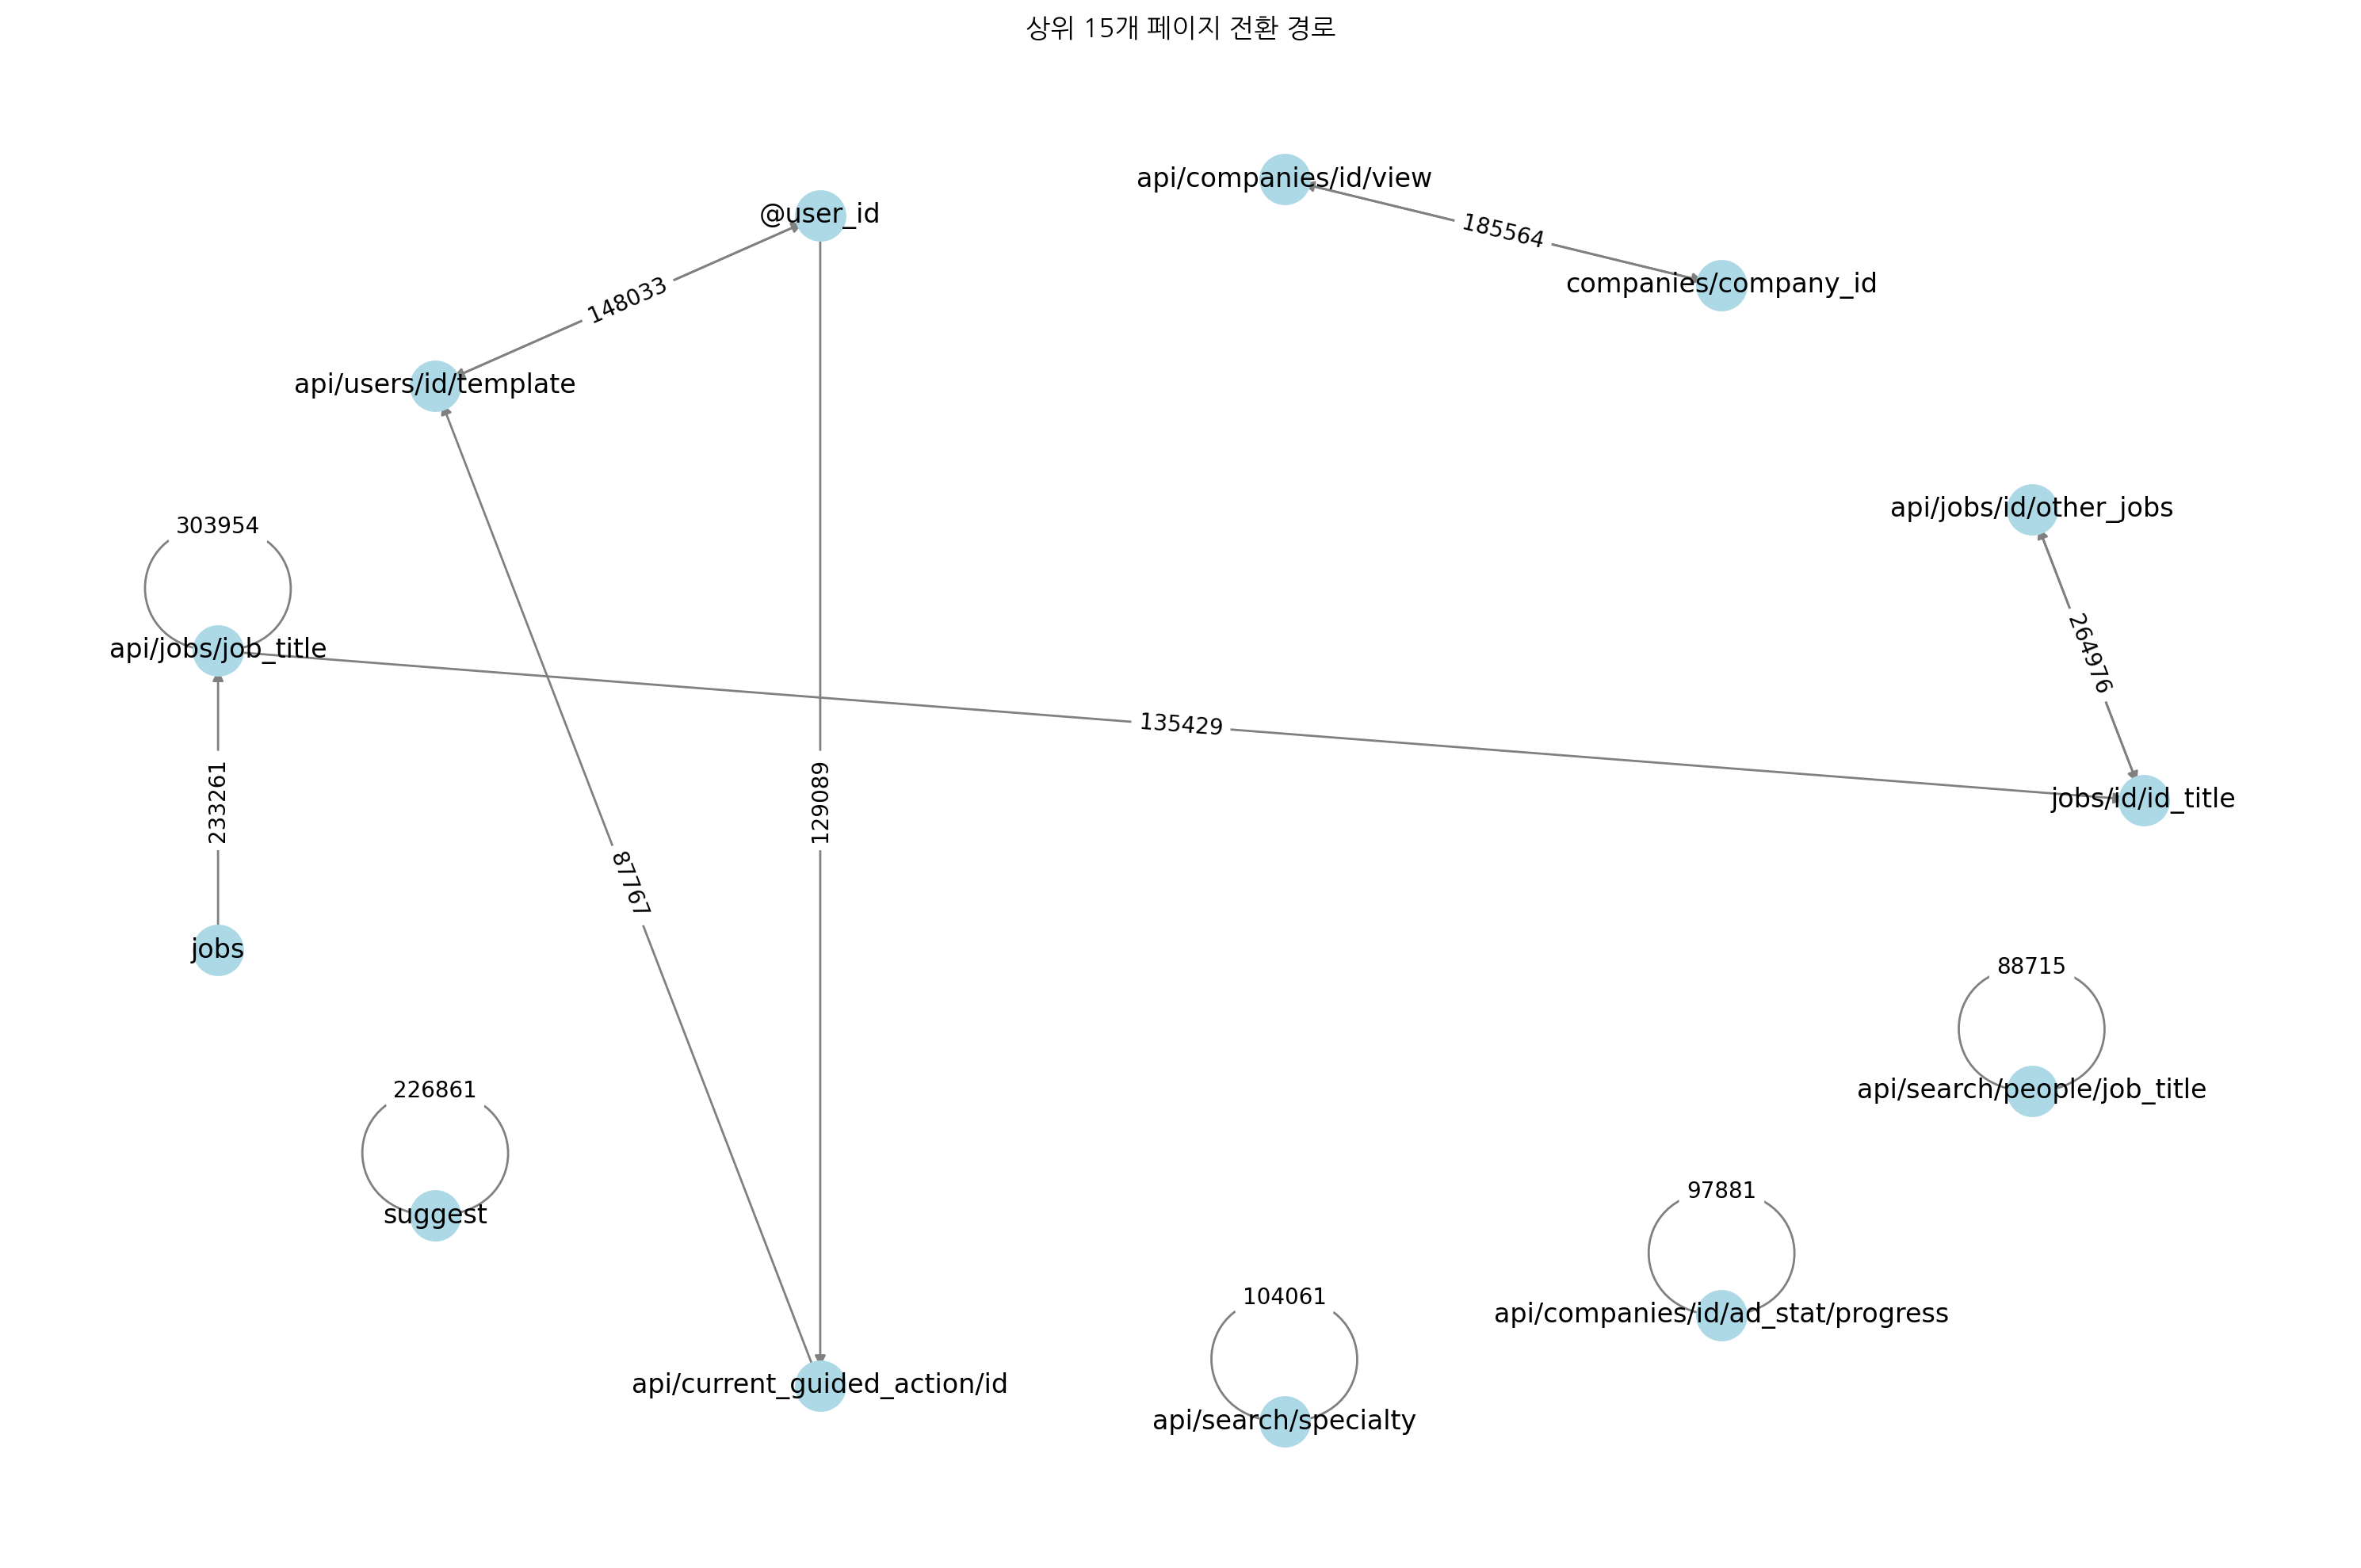

In [ ]:
def analyze_user_journeys(df):
    user_journeys = defaultdict(list)
    page_transitions = defaultdict(lambda: defaultdict(int))
    
    # 데이터프레임을 직접 처리
    df = df.sort_values(['user_uuid', 'timestamp'])
    
    for user, user_data in df.groupby('user_uuid'):
        journey = user_data['base_URL'].tolist()
        user_journeys[user] = journey
        
        for i in range(len(journey) - 1):
            page_transitions[journey[i]][journey[i+1]] += 1
    
    # 여정 분석 결과
    journey_analysis = {
        'total_users': len(user_journeys),
        'journey_lengths': {
            'mean': np.mean([len(journey) for journey in user_journeys.values()]),
            'median': np.median([len(journey) for journey in user_journeys.values()]),
            'min': min(len(journey) for journey in user_journeys.values()),
            'max': max(len(journey) for journey in user_journeys.values())
        }
    }
    
    # 상위 15개 페이지 전환 경로
    top_transitions = sorted(
        [(start, end, count) for start, ends in page_transitions.items() 
         for end, count in ends.items()],
        key=lambda x: x[2], 
        reverse=True
    )[:15]
    
    # 페이지 전환 네트워크 그래프 생성
    G = nx.DiGraph()
    for start, end, count in top_transitions:
        G.add_edge(start, end, weight=count)
    
    plt.figure(figsize=(15, 10))
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
    nx.draw_networkx_labels(G, pos)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title('상위 15개 페이지 전환 경로')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('user_journey_network.png')
    
    # 결과 출력
    print("사용자 여정 분석 결과:")
    print(f"총 사용자 수: {journey_analysis['total_users']}")
    print("\n여정 길이 통계:")
    for key, value in journey_analysis['journey_lengths'].items():
        print(f"{key}: {value:.2f}")
    
    print("\n상위 15개 페이지 전환 경로:")
    for start, end, count in top_transitions:
        print(f"{start} → {end}: {count}회")
    
    return user_journeys, page_transitions


user_journeys, page_transitions = analyze_user_journeys(df_log_2022)